In [30]:
import jax.numpy as jnp
import jax
import jax.random as random

jax.config.update("jax_debug_nans", True)


In [31]:
nSimul = 32768 * 10
#nSimul = 100000
spot = 100
vol = 0.2
T1 = 1
T2 = 2
K = 110

In [32]:

key = random.PRNGKey(0)
key, subkey = random.split(key)

# simulate returns (N1, N2) first
# returns: matrix [scenario, time]
returns = random.normal(key, shape=(nSimul,2))

# calculate S1 and S2
# both vectors of shape [nSimul]
S1 = spot * jnp.exp(-0.5*vol*vol*T1 + vol*jnp.sqrt(T1)*returns[:,0])
S2 = S1 * jnp.exp(-0.5*vol*vol*(T2-T1) + vol*jnp.sqrt(T2-T1)*returns[:,1])

# regression data, both vectors of shape [nSimul]
X = S1
Y = jnp.maximum(0, S2 - K)

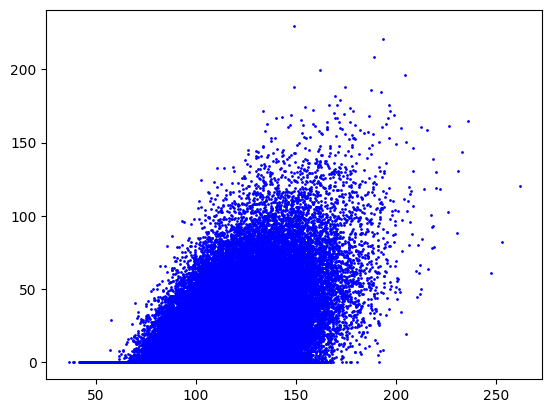

In [33]:
# display simulated data
import matplotlib.pyplot as plt
plt.plot(X, Y, 'bo', markersize=1)
plt.show()

Black-Scholes price:  3.9877625


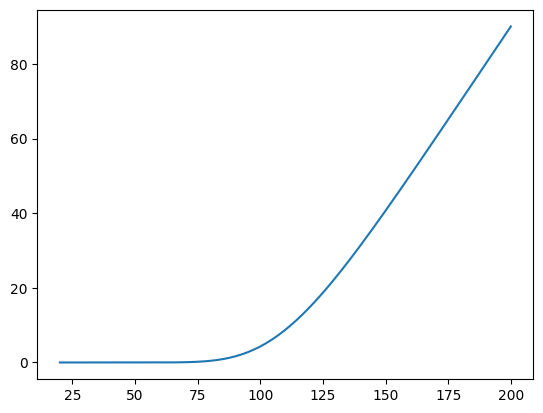

In [34]:
from jax.scipy.stats import norm

def BlackScholes(spot, strike, vol, T):
    d1 = (jnp.log(spot/strike) + 0.5*vol*vol*(T)) / (vol*jnp.sqrt(T))
    d2 = d1 - vol*jnp.sqrt(T)
    return spot*norm.cdf(d1) - strike*norm.cdf(d2)

# print("Black-Scholes price: ", BlackScholes(spot, K, vol, T))

def bs(spot):
    return BlackScholes(spot, K, vol, 1.)

print("Black-Scholes price: ", BlackScholes(100, 100, .1, 1.))

# plot true prices:

x_axis = jnp.linspace(20, 200, 150)
plt.plot(x_axis, bs(x_axis))

In [35]:
meanX = jnp.mean(X)
stdX = jnp.std(X)
meanY = jnp.mean(Y)
stdY = jnp.std(Y)

# normalize X and Y
normX = (X - meanX) / stdX
normY = (Y - meanY) / stdY

In [36]:
import jax
import jax.random
import jax.numpy as jnp

from jax import grad, vmap, jit, value_and_grad, jacfwd, jacrev

import equinox as eqx
import optax

import chex

from typing import Sequence
from jaxtyping import Array, Float, Int, PyTree

In [37]:
# Hyperparameters
batch_size = 128
learning_rate = 0.001
num_epochs = 10
seed = 42

key = jax.random.PRNGKey(seed)

In [38]:
key, subkey = jax.random.split(key)
model = eqx.nn.MLP(key=subkey, in_size=1, out_size=1, width_size=20, depth=3, activation=jax.nn.elu)
print(model)

MLP(
  layers=[
    Linear(
      weight=f32[20,1],
      bias=f32[20],
      in_features=1,
      out_features=20,
      use_bias=True
    ),
    Linear(
      weight=f32[20,20],
      bias=f32[20],
      in_features=20,
      out_features=20,
      use_bias=True
    ),
    Linear(
      weight=f32[20,20],
      bias=f32[20],
      in_features=20,
      out_features=20,
      use_bias=True
    ),
    Linear(
      weight=f32[1,20],
      bias=f32[1],
      in_features=20,
      out_features=1,
      use_bias=True
    )
  ],
  activation=<wrapped function elu>,
  final_activation=<function _identity>,
  in_size=1,
  out_size=1,
  width_size=20,
  depth=3
)


In [39]:
model.layers[0].weight.shape

(20, 1)

In [40]:
def loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"]) -> Float[Array, ""]:
    predictions = vmap(model)(x)
    targets = y
    chex.assert_type([predictions], float)
    if targets is not None:
        # Avoid broadcasting logic for "-" operator.
        chex.assert_equal_shape((predictions, targets))
    errors = predictions - targets if targets is not None else predictions
    # jax.debug.print("{error}", error=errors)
    result = jnp.mean(errors ** 2)
    chex.assert_type([result], float)
    return result

    # pred_y = vmap(model)(x)
    # return jnp.mean(jnp.square(y - pred_y))
    # return jnp.mean((y - pred_y) ** 2)

In [41]:
normX = normX[:,jnp.newaxis]
normY = normY[:,jnp.newaxis]

print(normX)
print(normX.shape)
print(normY)
print(normY.shape)

[[-1.0286547 ]
 [-1.0746337 ]
 [-1.1065419 ]
 ...
 [ 1.1608996 ]
 [-0.6177425 ]
 [ 0.18155591]]
(327680, 1)
[[-0.4559105]
 [-0.4559105]
 [-0.4559105]
 ...
 [ 3.5841458]
 [-0.4559105]
 [-0.4559105]]
(327680, 1)


In [51]:
#loss = eqx.filter_jit(loss_fn)
loss = loss_fn
optim = optax.adamw(learning_rate)

def train(model: eqx.nn.MLP,
          x: Float[Array, "n_samples"], 
          y: Float[Array, "n_samples"],
          optim: optax.GradientTransformation,
          steps: int) -> PyTree:

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP, opt_state: PyTree, x: Float[Array, "batch"], y: Float[Array, "batch"]) -> PyTree:
        # loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        grad_fn = eqx.filter_jit(eqx.filter_value_and_grad(loss))
        # jax.make_jaxpr(grad_fn)(model, x, y)

        jaxpr_info = eqx.filter_make_jaxpr(grad_fn)(model, x, y)

        loss_value, grads = grad_fn(model, x, y)
        # jax.debug.print(grads)

        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, loss_value, jaxpr_info


    n_batches = (len(x) // batch_size)
    # n_epochs = steps // n_batches
    for step in range(n_batches):
        batch_x = x[step*batch_size:(step+1)*batch_size]
        batch_y = y[step*batch_size:(step+1)*batch_size]

        # print(f"batch_x: {batch_x.shape}, batch_y: {batch_y.shape}")
        # print(f"batch_x: {batch_x}, batch_y: {batch_y}")
        model, loss_value, jaxpr_info = train_step(model, opt_state, batch_x, batch_y)

        # print(jaxpr_info)

        if (step % 100 == 0) or (step == steps-1):
            print(f"step: {step}, train_loss: {loss_value}")
            #evaluate(model)

    return model

model = train(model, normX, normY, optim, steps=1000)



step: 0, train_loss: 0.5805679559707642
step: 100, train_loss: 0.5700846910476685
step: 200, train_loss: 0.6684929132461548
step: 300, train_loss: 0.7045645713806152
step: 400, train_loss: 0.6163510084152222
step: 500, train_loss: 0.6503121852874756
step: 600, train_loss: 0.5670435428619385
step: 700, train_loss: 0.4137597382068634
step: 800, train_loss: 0.5375144481658936
step: 900, train_loss: 0.7347450256347656
step: 999, train_loss: 0.6377686262130737
step: 1000, train_loss: 0.6157316565513611
step: 1100, train_loss: 0.8811391592025757
step: 1200, train_loss: 0.5577868223190308
step: 1300, train_loss: 0.6953514218330383
step: 1400, train_loss: 0.5843149423599243
step: 1500, train_loss: 0.5326011776924133
step: 1600, train_loss: 0.45211708545684814
step: 1700, train_loss: 0.6868398189544678
step: 1800, train_loss: 0.4689610004425049
step: 1900, train_loss: 0.38517820835113525
step: 2000, train_loss: 0.4822087585926056
step: 2100, train_loss: 0.7044093012809753
step: 2200, train_loss

In [61]:
def evaluate(model: eqx.nn.MLP, x: Float[Array, "n_samples"], targets: Float[Array, "n_samples"]):
    x = x[:,jnp.newaxis]

    # normalize x
    x = (x - meanX) / stdX

    pred_y = vmap(model)(x)

    # unscale predictions
    pred_y = pred_y * stdY + meanY
    return pred_y

def visualize(x: Float[Array, "n_samples"], pred_y: Float[Array, "n_samples"], targets: Float[Array, "n_samples"]):
    plt.plot(x, pred_y, 'r.', markersize=1)
    plt.plot(x, targets, 'b')
    plt.show()

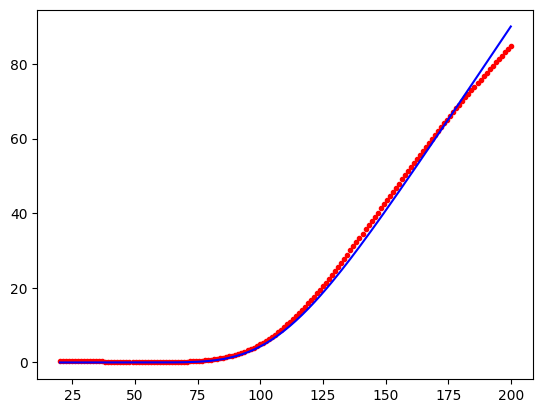

In [62]:
targets = bs(x_axis)
pred_y = evaluate(model, x_axis, targets)

visualize(x_axis, pred_y, targets)